In [27]:
!sudo apt-get install -y openjdk-17-jdk

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
openjdk-17-jdk is already the newest version (17.0.16+8~us1-0ubuntu1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [28]:
!pip install -q pyspark

from pyspark.sql import SparkSession, functions as F, Window

spark = (SparkSession.builder
         .appName("NBA-PlayByPlay-PA5")
         .config("spark.sql.shuffle.partitions", "8")
         .config("spark.driver.memory", "4g")
         .getOrCreate())

spark

In [29]:
import pyspark
from pyspark.sql import SparkSession
print("PySpark:", pyspark.__version__)

spark = (
    SparkSession.builder
    .appName("team7-sports-nba-sprint5")
    .config("spark.sql.shuffle.partitions", "200")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)
print("Spark:", spark.version)

PySpark: 3.5.1
Spark: 3.5.1


In [30]:
from google.colab import files
up = files.upload()   # pick your clean_play_by_play.csv file
!mkdir -p /content/outputs/tables /content/outputs/figures

Saving clean_play_by_play.csv to clean_play_by_play (1).csv


In [31]:
PBP_PATH = "/content/clean_play_by_play.csv"
pbp = (spark.read
       .option("header", True)
       .csv(PBP_PATH))

pbp.printSchema()
print("Number of Rows:", pbp.count())
pbp.show(5, truncate=False)

root
 |-- game_id: string (nullable = true)
 |-- period: string (nullable = true)
 |-- pctimestring: string (nullable = true)
 |-- eventmsgtype: string (nullable = true)
 |-- eventmsgactiontype: string (nullable = true)
 |-- actor_id: string (nullable = true)
 |-- actor_name: string (nullable = true)
 |-- actor_team_id: string (nullable = true)
 |-- actor_team_abbr: string (nullable = true)
 |-- homedescription: string (nullable = true)
 |-- visitordescription: string (nullable = true)

Number of Rows: 925
+--------+------+------------------------+------------+------------------+--------+--------------+-------------+---------------+--------------------------------------------+--------------------------+
|game_id |period|pctimestring            |eventmsgtype|eventmsgactiontype|actor_id|actor_name    |actor_team_id|actor_team_abbr|homedescription                             |visitordescription        |
+--------+------+------------------------+------------+------------------+--------+---

In [32]:
from pyspark.sql import functions as F

#filter the datset to keep only rows representing the rebound events
rebounds = pbp.filter(F.col("eventmsgtype") == 4)
player_rebnd_stats = (
    rebounds
    .groupBy("actor_id", "actor_name", "actor_team_abbr")
    .agg(
        F.count("*").alias("total_rebounds"),
        F.countDistinct("game_id").alias("games_played")
    )
    .orderBy(F.desc("total_rebounds"))
)

player_rebnd_stats.show(10, truncate=False

)

+--------+---------------------+---------------+--------------+------------+
|actor_id|actor_name           |actor_team_abbr|total_rebounds|games_played|
+--------+---------------------+---------------+--------------+------------+
|1903    |Kenny Thomas         |PHI            |3             |3           |
|101107  |Marvin Williams      |CHA            |2             |2           |
|2547    |Chris Bosh           |TOR            |2             |2           |
|2216    |Zach Randolph        |MEM            |2             |2           |
|203507  |Giannis Antetokounmpo|MIL            |2             |2           |
|203991  |Clint Capela         |ATL            |2             |2           |
|1502    |Adonal Foyle         |GSW            |2             |2           |
|703     |Kurt Thomas          |NYK            |2             |2           |
|203081  |Damian Lillard       |POR            |1             |1           |
|1917    |Wang Zhi-zhi         |DAL            |1             |1           |

In [33]:
pbp_with_date = (
    pbp
    .withColumn("event_time", F.to_timestamp("pctimestring"))
    .withColumn("season_year", F.year("event_time").cast("string"))
)

season_map = [("2023", "2023-24"),
              ("2024", "2024-25"),
              ("2025", "2025-26")
          ]
season_df = spark.createDataFrame(season_map, ["season_year", "season_label"])
pbp_joined = pbp_with_date.join(season_df, "season_year", "left")

rebounds_joined = pbp_joined.filter(F.col("eventmsgtype") == 4)

player_season_rebnd = (
    rebounds_joined
    .groupBy("season_label", "actor_id", "actor_name")
    .agg(F.count("*").alias("total_rebounds_season"),
         F.countDistinct("game_id").alias("game_played"),
         (F.count("*") / F.countDistinct("game_id")).alias("avg_rebnd_per_game"))
    .orderBy(F.desc("total_rebounds_season"))
)
print("Seasonal rebound summary per player:")
player_season_rebnd.show(10, truncate=False)

Seasonal rebound summary per player:
+------------+--------+----------------+---------------------+-----------+------------------+
|season_label|actor_id|actor_name      |total_rebounds_season|game_played|avg_rebnd_per_game|
+------------+--------+----------------+---------------------+-----------+------------------+
|2025-26     |1903    |Kenny Thomas    |4                    |4          |1.0               |
|2025-26     |203991  |Clint Capela    |3                    |3          |1.0               |
|2025-26     |201142  |Kevin Durant    |2                    |2          |1.0               |
|2025-26     |2549    |Chris Kaman     |2                    |2          |1.0               |
|2025-26     |2730    |Dwight Howard   |2                    |2          |1.0               |
|2025-26     |2547    |Chris Bosh      |2                    |2          |1.0               |
|2025-26     |203482  |Kelly Olynyk    |2                    |2          |1.0               |
|2025-26     |101107  |

In [34]:
# Uses the file you uploaded earlier
PBP_PATH = "/content/clean_play_by_play.csv"

from pyspark.sql.functions import col

plays_eng3 = (spark.read
              .option("header", True)
              .option("inferSchema", True)
              .csv(PBP_PATH))

# Auto-detect the event column so we don't depend on ENG2 names
event_col = None
for c in plays_eng3.columns:
    if "eventmsgtype" in c.lower():
        event_col = c
        break
if event_col is None:
    raise ValueError("Could not find an 'eventmsgtype' column. Print columns and tell me the exact header.")

eng3_base = (plays_eng3
    .select(
        col("game_id").cast("string"),
        col("actor_team_abbr").alias("team").cast("string"),
        col(event_col).alias("event_code").cast("int"),
    )
    .na.drop(subset=["team","game_id","event_code"])
)

eng3_base.show(5, truncate=False)

+--------+----+----------+
|game_id |team|event_code|
+--------+----+----------+
|29900841|NJN |8         |
|29800096|DAL |2         |
|29900023|SAS |1         |
|21801115|DET |1         |
|21600503|CHI |1         |
+--------+----+----------+
only showing top 5 rows



In [35]:
from pyspark.sql.functions import expr, sum as _sum, count, desc

# Attempts proxy: event_code in {1,2,3}
eng3_shots = eng3_base.withColumn(
    "shot_att",
    expr("CASE WHEN event_code IN (1,2,3) THEN 1 ELSE 0 END")
)

# Optional quick frequency (purely ENG3-owned; doesn't change ENG2’s)
eng3_freq = (eng3_base.groupBy("event_code").agg(count("*").alias("events"))
             .orderBy(desc("events")))
# eng3_freq.show(10)

In [36]:
from pyspark.sql.functions import when, round, countDistinct

eng3_rates = (eng3_shots
    .withColumn("made_shot", when(col("event_code") == 1, 1).otherwise(0))
    .groupBy("team")
    .agg(
        _sum("made_shot").alias("made_shots"),
        _sum("shot_att").alias("shot_attempts"),
        countDistinct("game_id").alias("games")
    )
    .withColumn("fg_rate",
        round(col("made_shots") / when(col("shot_attempts")==0, None).otherwise(col("shot_attempts")), 3)
    )
    .withColumn("plays_per_game",
        round(col("shot_attempts") / when(col("games")==0, None).otherwise(col("games")), 2)
    )
)

eng3_buckets = (eng3_rates
    .withColumn(
        "tier",
        when(col("fg_rate") >= 0.55, "Elite")
        .when((col("fg_rate") >= 0.48) & (col("fg_rate") < 0.55), "Above Avg")
        .when((col("fg_rate") >= 0.42) & (col("fg_rate") < 0.48), "Average")
        .otherwise("Below Avg")
    )
    .orderBy(col("fg_rate").desc())
)

eng3_buckets.show(15, truncate=False)

+----+----------+-------------+-----+-------+--------------+---------+
|team|made_shots|shot_attempts|games|fg_rate|plays_per_game|tier     |
+----+----------+-------------+-----+-------+--------------+---------+
|OKC |7         |11           |22   |0.636  |0.5           |Elite    |
|NJN |3         |5            |12   |0.6    |0.42          |Elite    |
|GSW |5         |9            |22   |0.556  |0.41          |Elite    |
|CHH |1         |2            |5    |0.5    |0.4           |Above Avg|
|VAN |1         |2            |8    |0.5    |0.25          |Above Avg|
|SAS |8         |16           |32   |0.5    |0.5           |Above Avg|
|MIN |7         |14           |25   |0.5    |0.56          |Above Avg|
|NOP |3         |6            |13   |0.5    |0.46          |Above Avg|
|CHI |5         |10           |28   |0.5    |0.36          |Above Avg|
|CLE |11        |23           |33   |0.478  |0.7           |Average  |
|BOS |4         |9            |26   |0.444  |0.35          |Average  |
|MIL |

In [46]:
from pyspark.sql.functions import desc, sum as _sum

topn_teams = (
    eng3_shots.groupBy("team")
    .agg(_sum("shot_att").alias("shot_attempts"))
    .orderBy(desc("shot_attempts"))
    .limit(15)
)

topn_teams.show(15, truncate=False)

+----+-------------+
|team|shot_attempts|
+----+-------------+
|SAC |26           |
|HOU |25           |
|CLE |23           |
|DAL |22           |
|MIL |22           |
|UTA |21           |
|MEM |20           |
|MIA |19           |
|PHI |18           |
|SAS |16           |
|DEN |16           |
|NYK |16           |
|DET |15           |
|POR |15           |
|LAC |15           |
+----+-------------+



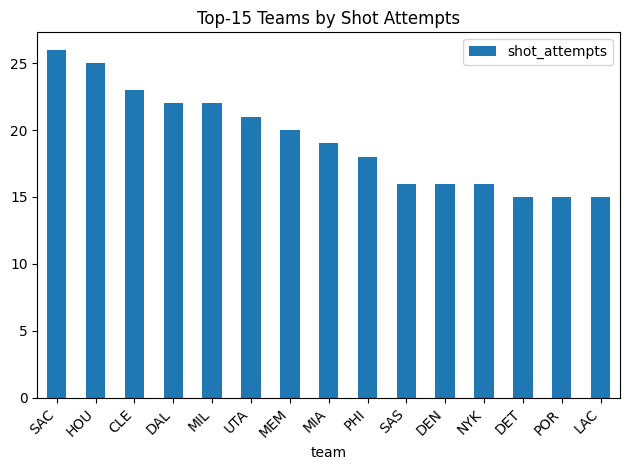

In [47]:
# write table for grading
topn_teams.write.mode("overwrite").parquet("out/topn_teams.parquet")

# quick figure
pdf = topn_teams.toPandas()
ax = pdf.plot.bar(x="team", y="shot_attempts", title="Top-15 Teams by Shot Attempts")
import matplotlib.pyplot as plt
plt.xticks(rotation=45, ha="right"); plt.tight_layout()
plt.savefig("out/topn_teams.png", dpi=150); plt.show()